# VAR: Vector Autoregression

### Importing Relevant Packages

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [2]:
plt.rcParams['figure.figsize'] = [10,7.5]

## United States Macroeconomic Dataset

In [23]:
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### We will be predicting Real GDP and Real CONS

Plotting Real GDP and Real CONS

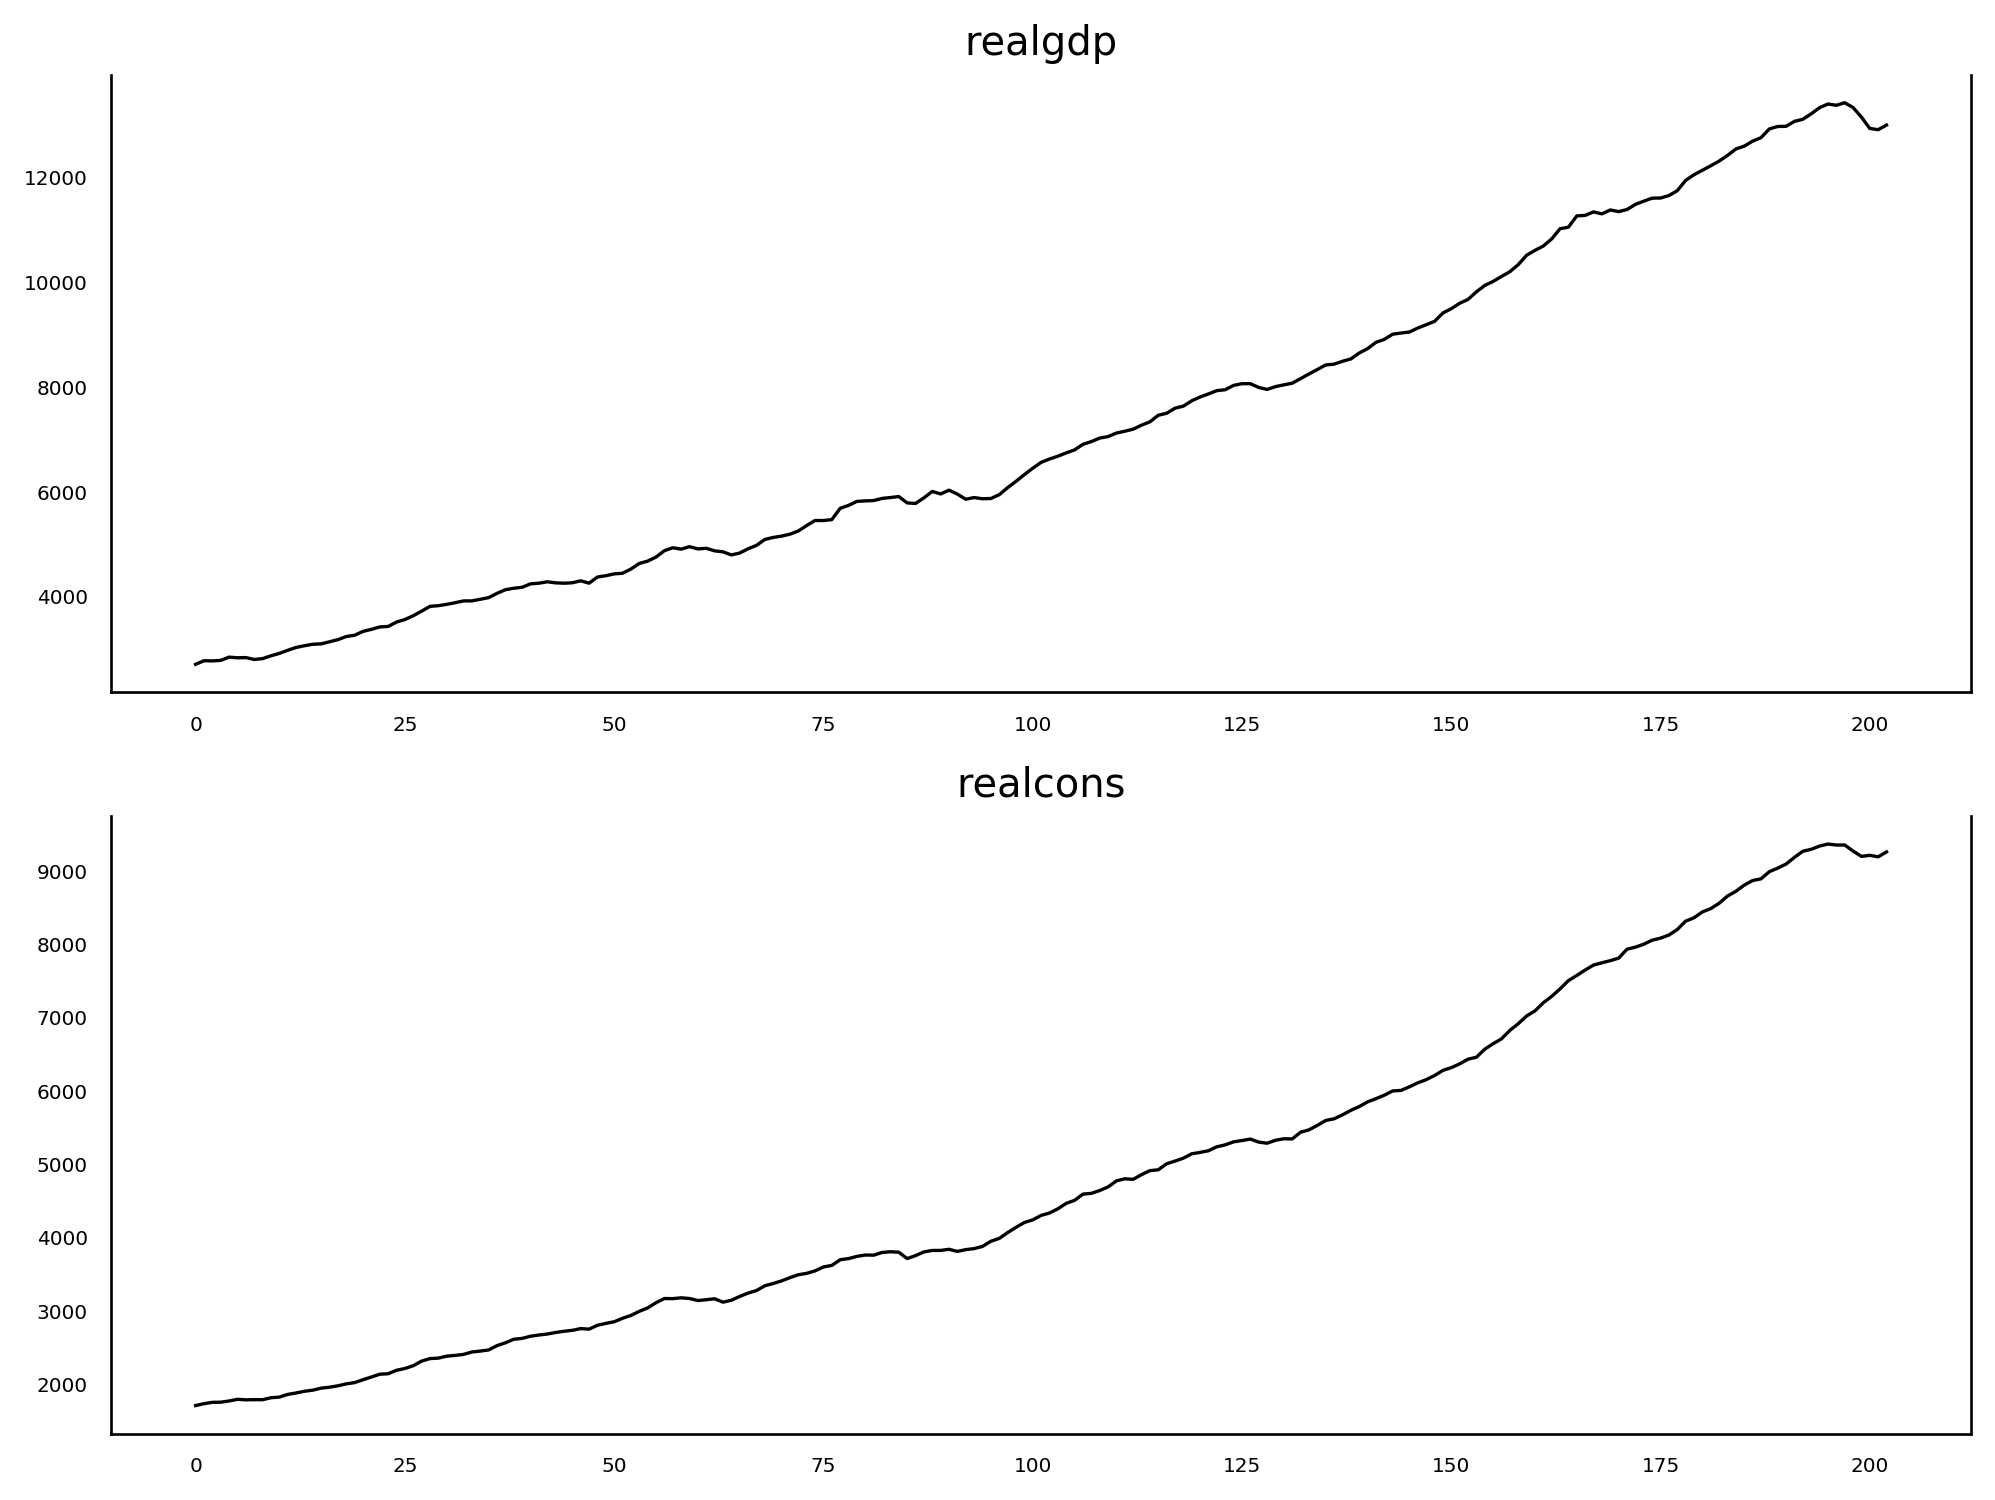

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi = 240)

ax1.plot(macro_data['realgdp'], color='black', linewidth = 1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)


ax2.plot(macro_data['realcons'], color='black', linewidth = 1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

Since we know that both time series are increasing over time, we know they are not stationary. We're going to take the difference. 

The output shows stationarity in p-value and adf stat (small and negative). 

In [6]:
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print('realgdp')

print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n------------------------------------------')

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print('realcons')

print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08

------------------------------------------
realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


VAR does not consider the order of integration. Only ARIMA, (I) considers that. Taking the difference isn't useful just yet but it will become useful later. 

### Creating a Function to Identify the Best Order for VAR

In this function we're optimizing with MSE instead of AIC as an example of another option of what we can do. 

For the order, it is (i,0) because in this case we are only considering the AR portion of the model so we are forcing q to be zero and only focusing on i which is p. 

In [7]:
def optimize_VAR(endog): 
    '''
    Returns dataframe w parameters and corresponding MSE
    
    endog - observed time series
    
    '''
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i,0)).fit(dips=False)
        except: 
            continue
            
        mse = model.mse
        results.append([i,mse])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by = 'mse', ascending = True).reset_index(drop = True)
    
    return result_df
            
            
            

In [9]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)

result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse
0,13,1.456859e+05
1,12,1.474253e+05
2,11,1.515953e+05
3,10,1.570343e+05
4,8,1.592668e+05
5,9,1.632634e+05
6,7,1.651857e+05
7,6,1.720026e+05
8,5,1.849547e+05
9,4,1.997864e+05


Our lowest MSE has a p value of 13. Let's fit the model to get a summary. 

In [10]:
best_model = VARMAX(endog, order = (13,0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(13)   Log Likelihood               -1978.598
                               + intercept   AIC                           4071.196
Date:                     Mon, 23 May 2022   BIC                           4260.048
Time:                             18:04:11   HQIC                          4147.598
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.03, 0.00   Jarque-Bera (JB):           4.83, 5.33
Prob(Q):                        0.87, 0.96   Prob(JB):                   0.09, 0.07
Heteroskedasticity (H):         1.74, 2.55   Skew:                       0.3

### Analysing the Residuals

Looking good and normal, so we are able to forecast. 

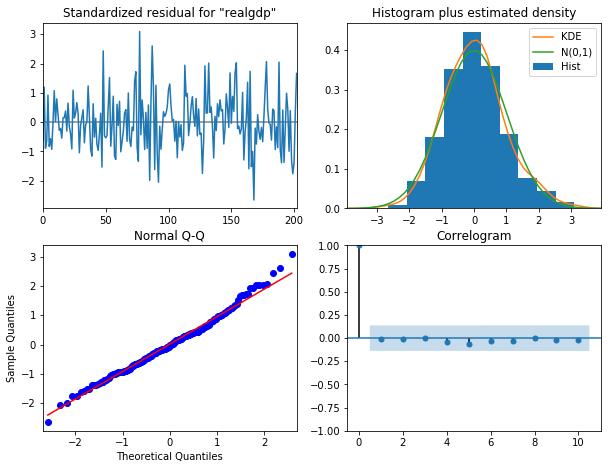

In [11]:
res.plot_diagnostics();

### Predictions

This will predict realgdp and realcons 3 lags into the future.

In [12]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,realgdp,realcons
204,13168.375214,9325.210984
205,13204.505370,9324.675762
206,13241.858016,9335.358777


### Plotting with Predictions

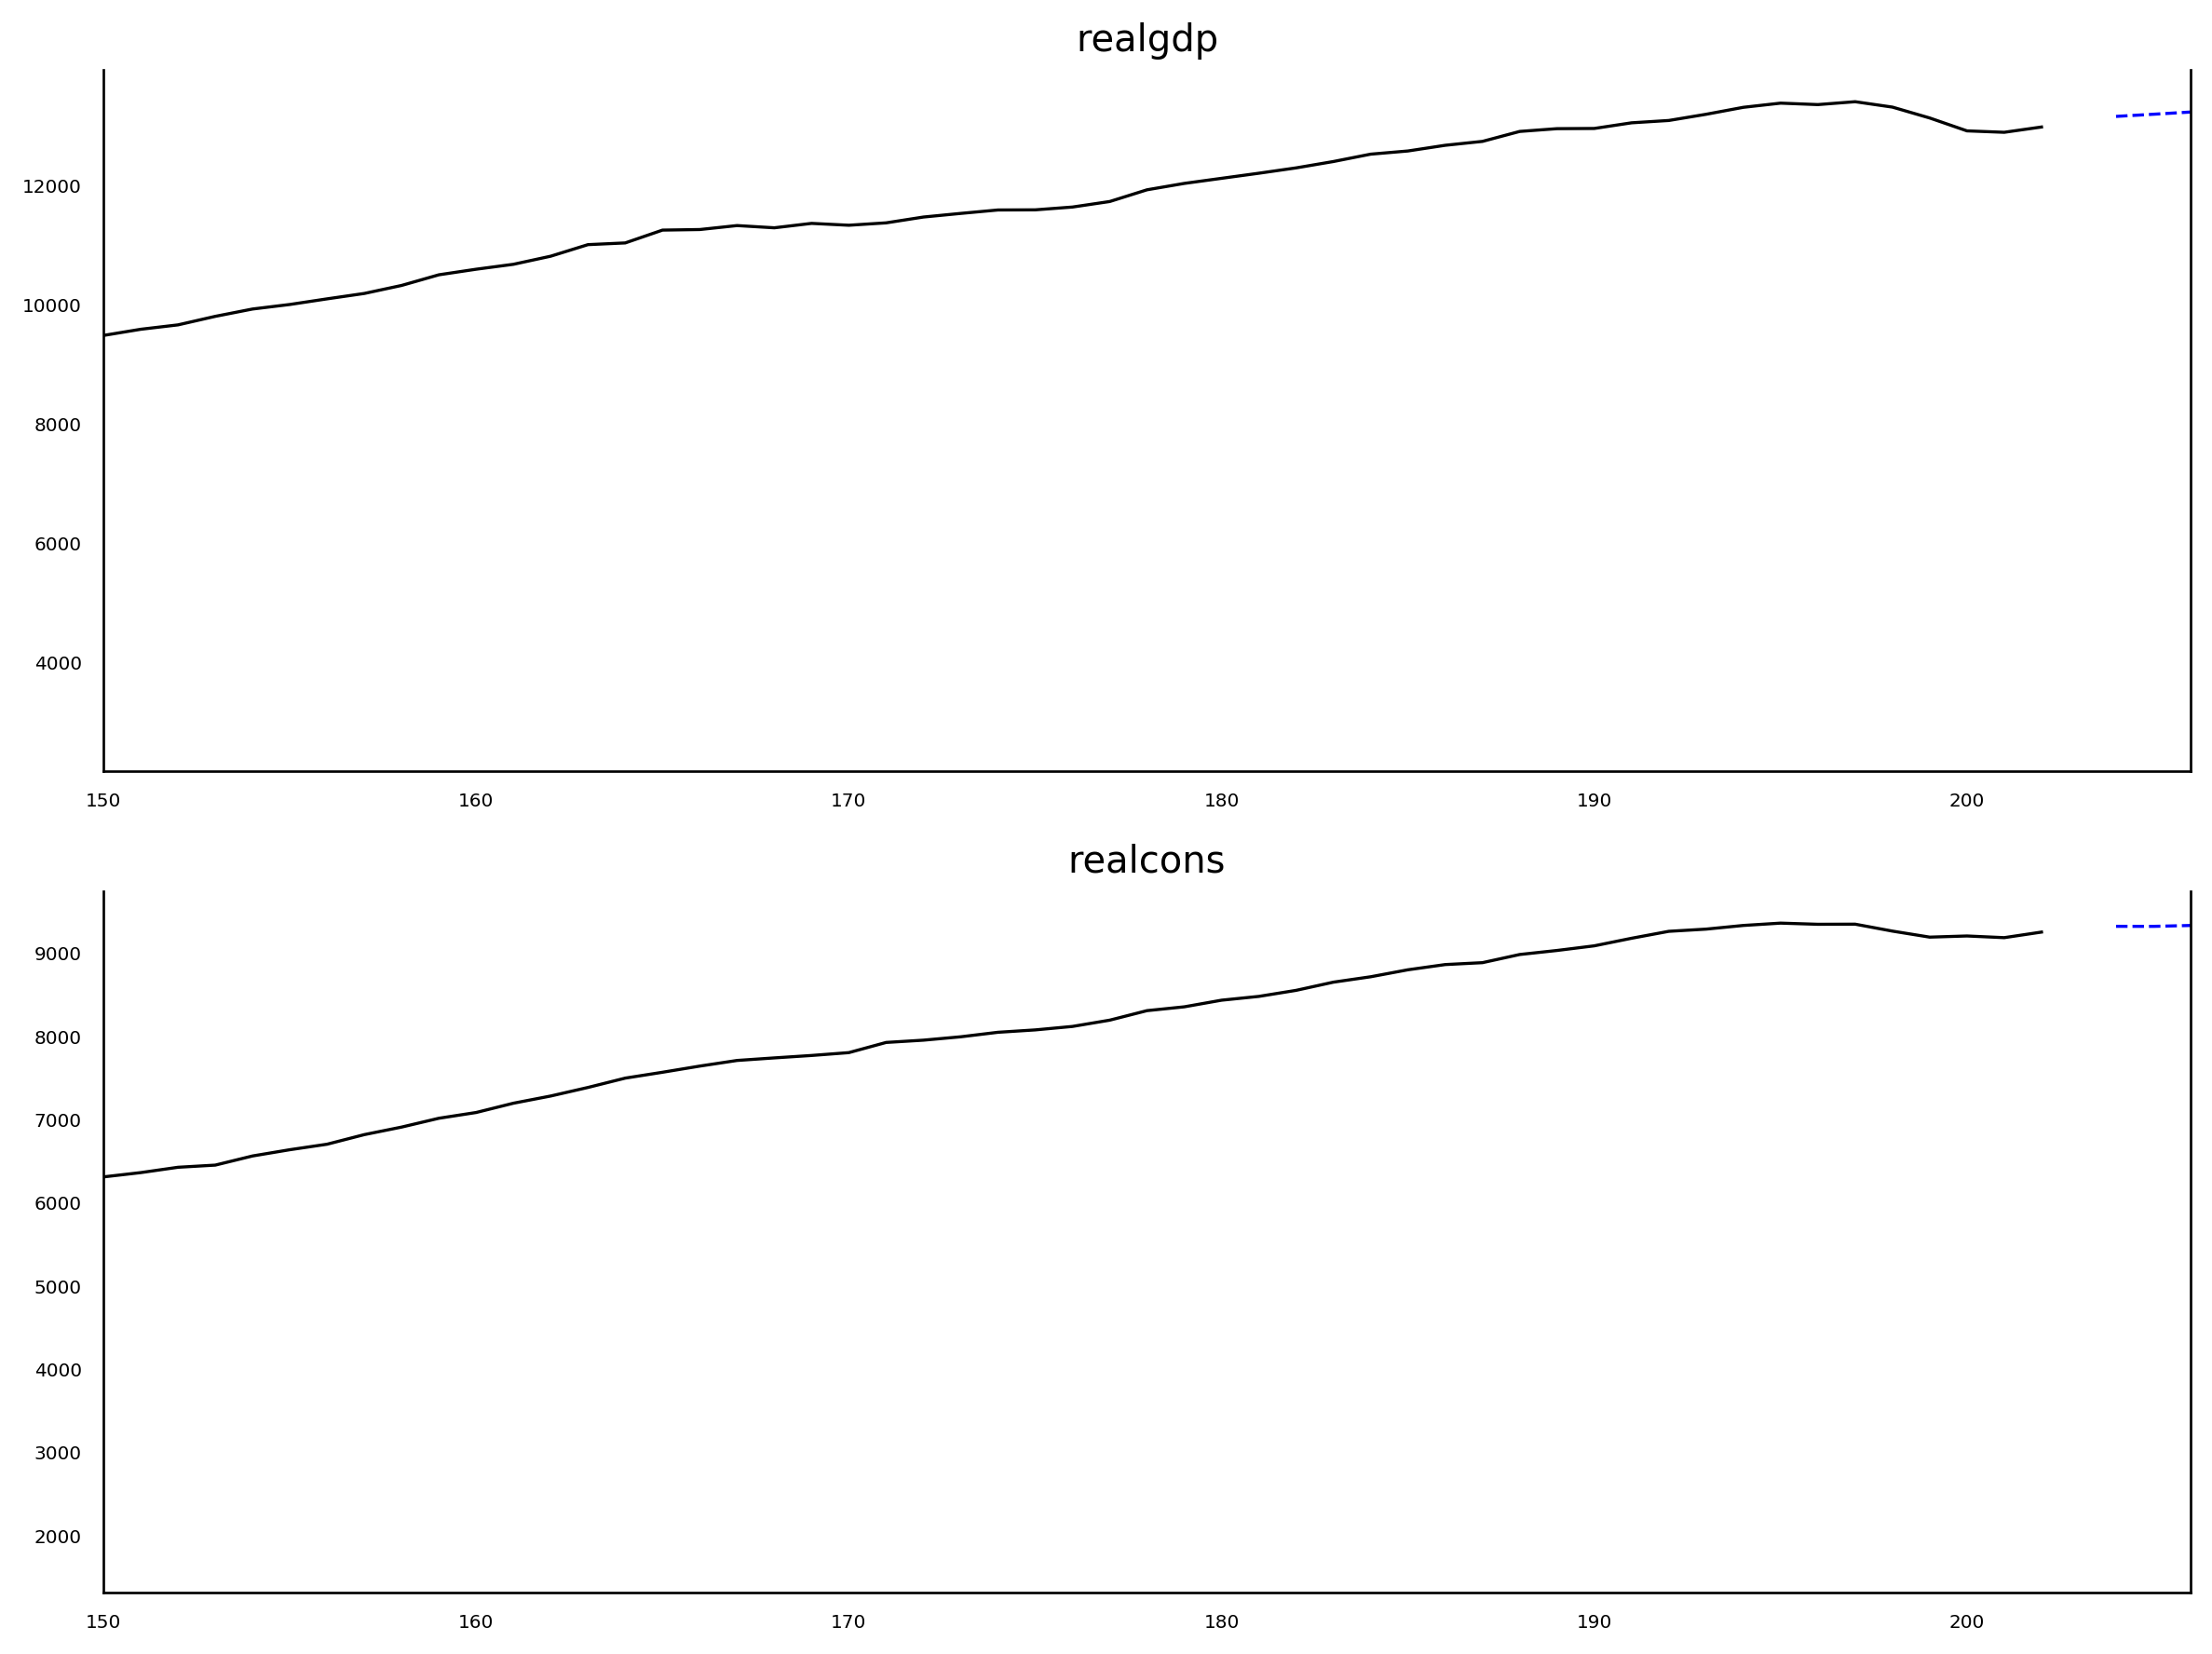

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color = 'black', linewidth = 1)
ax1.plot(idx[-n_forecast:],
        predict.predicted_mean['realgdp'][-n_forecast:],
        color = 'blue',
        ls='--',
        linewidth=1)


ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150,206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize = 6)


ax2.plot(macro_data['realcons'], color = 'black', linewidth = 1)
ax2.plot(idx[-n_forecast:],
        predict.predicted_mean['realcons'][-n_forecast:],
        color = 'blue',
        ls='--',
        linewidth=1)


ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150,206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

plt.tight_layout()

### Granger Causality Test

This is where taking the difference can be used. In this VAR example, the model is using each target variable to explain the other, so realcons could explain realgdp and vice versa. 

Now we need to run a statistical test to see if this is true or not. The Granger Causaility test runs a null hypothesis of no causality between the variables. If it has a p-val of less than .05, then the null hypothesis can be rejected and we can say there is significant evidence to suggest causality between the 2 variables. 

We will have to run 2 tests: 
1. Realcons causing RealGDP
2. RealGDP causing Realcons

Also, since we are skipping the first element since it will be NaN. 
We are skipping the stationarity test since we already did that earlier. 

13 here is the optimal lag that we found earlier for AR.

In [18]:
print('realcons causes realgdp?\n')
print('--------------------------')
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:],[13])

realcons causes realgdp?

--------------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=85.5708 , p=0.0000  , df=13
likelihood ratio test: chi2=70.5844 , p=0.0000  , df=13
parameter F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13


In [19]:
print('realgdp causes realcons?\n')
print('--------------------------')
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:],[13])

realgdp causes realcons?

--------------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=32.3973 , p=0.0021  , df=13
likelihood ratio test: chi2=29.9021 , p=0.0049  , df=13
parameter F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13


### Conclusion

Both are causing each other because all p-values are less than .05.

# VARMA

In [30]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding MSE
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(3, 1)",1.481748e+05
1,"(3, 2)",1.726070e+05
2,"(1, 1)",1.871747e+05
3,"(3, 3)",2.725602e+05
4,"(3, 0)",3.483687e+05
5,"(2, 1)",3.757367e+05
6,"(0, 1)",5.788891e+05
7,"(0, 3)",8.663932e+05
8,"(1, 3)",1.275392e+06
9,"(2, 2)",1.757310e+06


The Best Combination is (3,1). 3 is AR, 1 is MA. Let's fit the model. 

In [32]:
best_model_VARMA = VARMAX(endog, order=(3,1))

res_VARMA = best_model_VARMA.fit(disp = False)
print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                          VARMA(3,1)   Log Likelihood               -2001.085
                               + intercept   AIC                           4044.169
Date:                     Mon, 23 May 2022   BIC                           4113.747
Time:                             18:36:11   HQIC                          4072.317
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.64, 0.02   Jarque-Bera (JB):          3.44, 10.12
Prob(Q):                        0.42, 0.90   Prob(JB):                   0.18, 0.01
Heteroskedasticity (H):         2.50, 2.99   Skew:                       0.1

### Check out Residuals

Fairly normal, so you can make predictions.

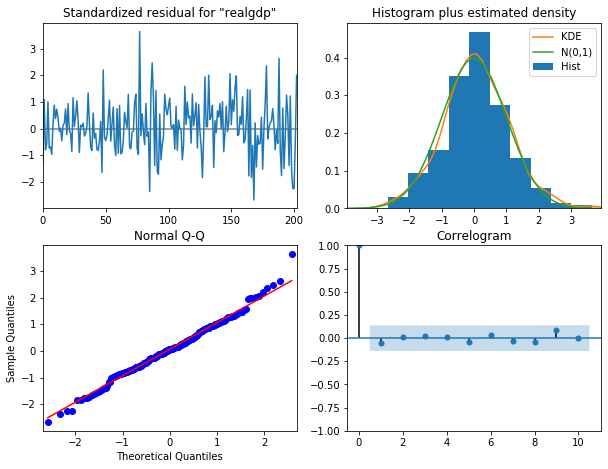

In [33]:
res_VARMA.plot_diagnostics();

### Predictions

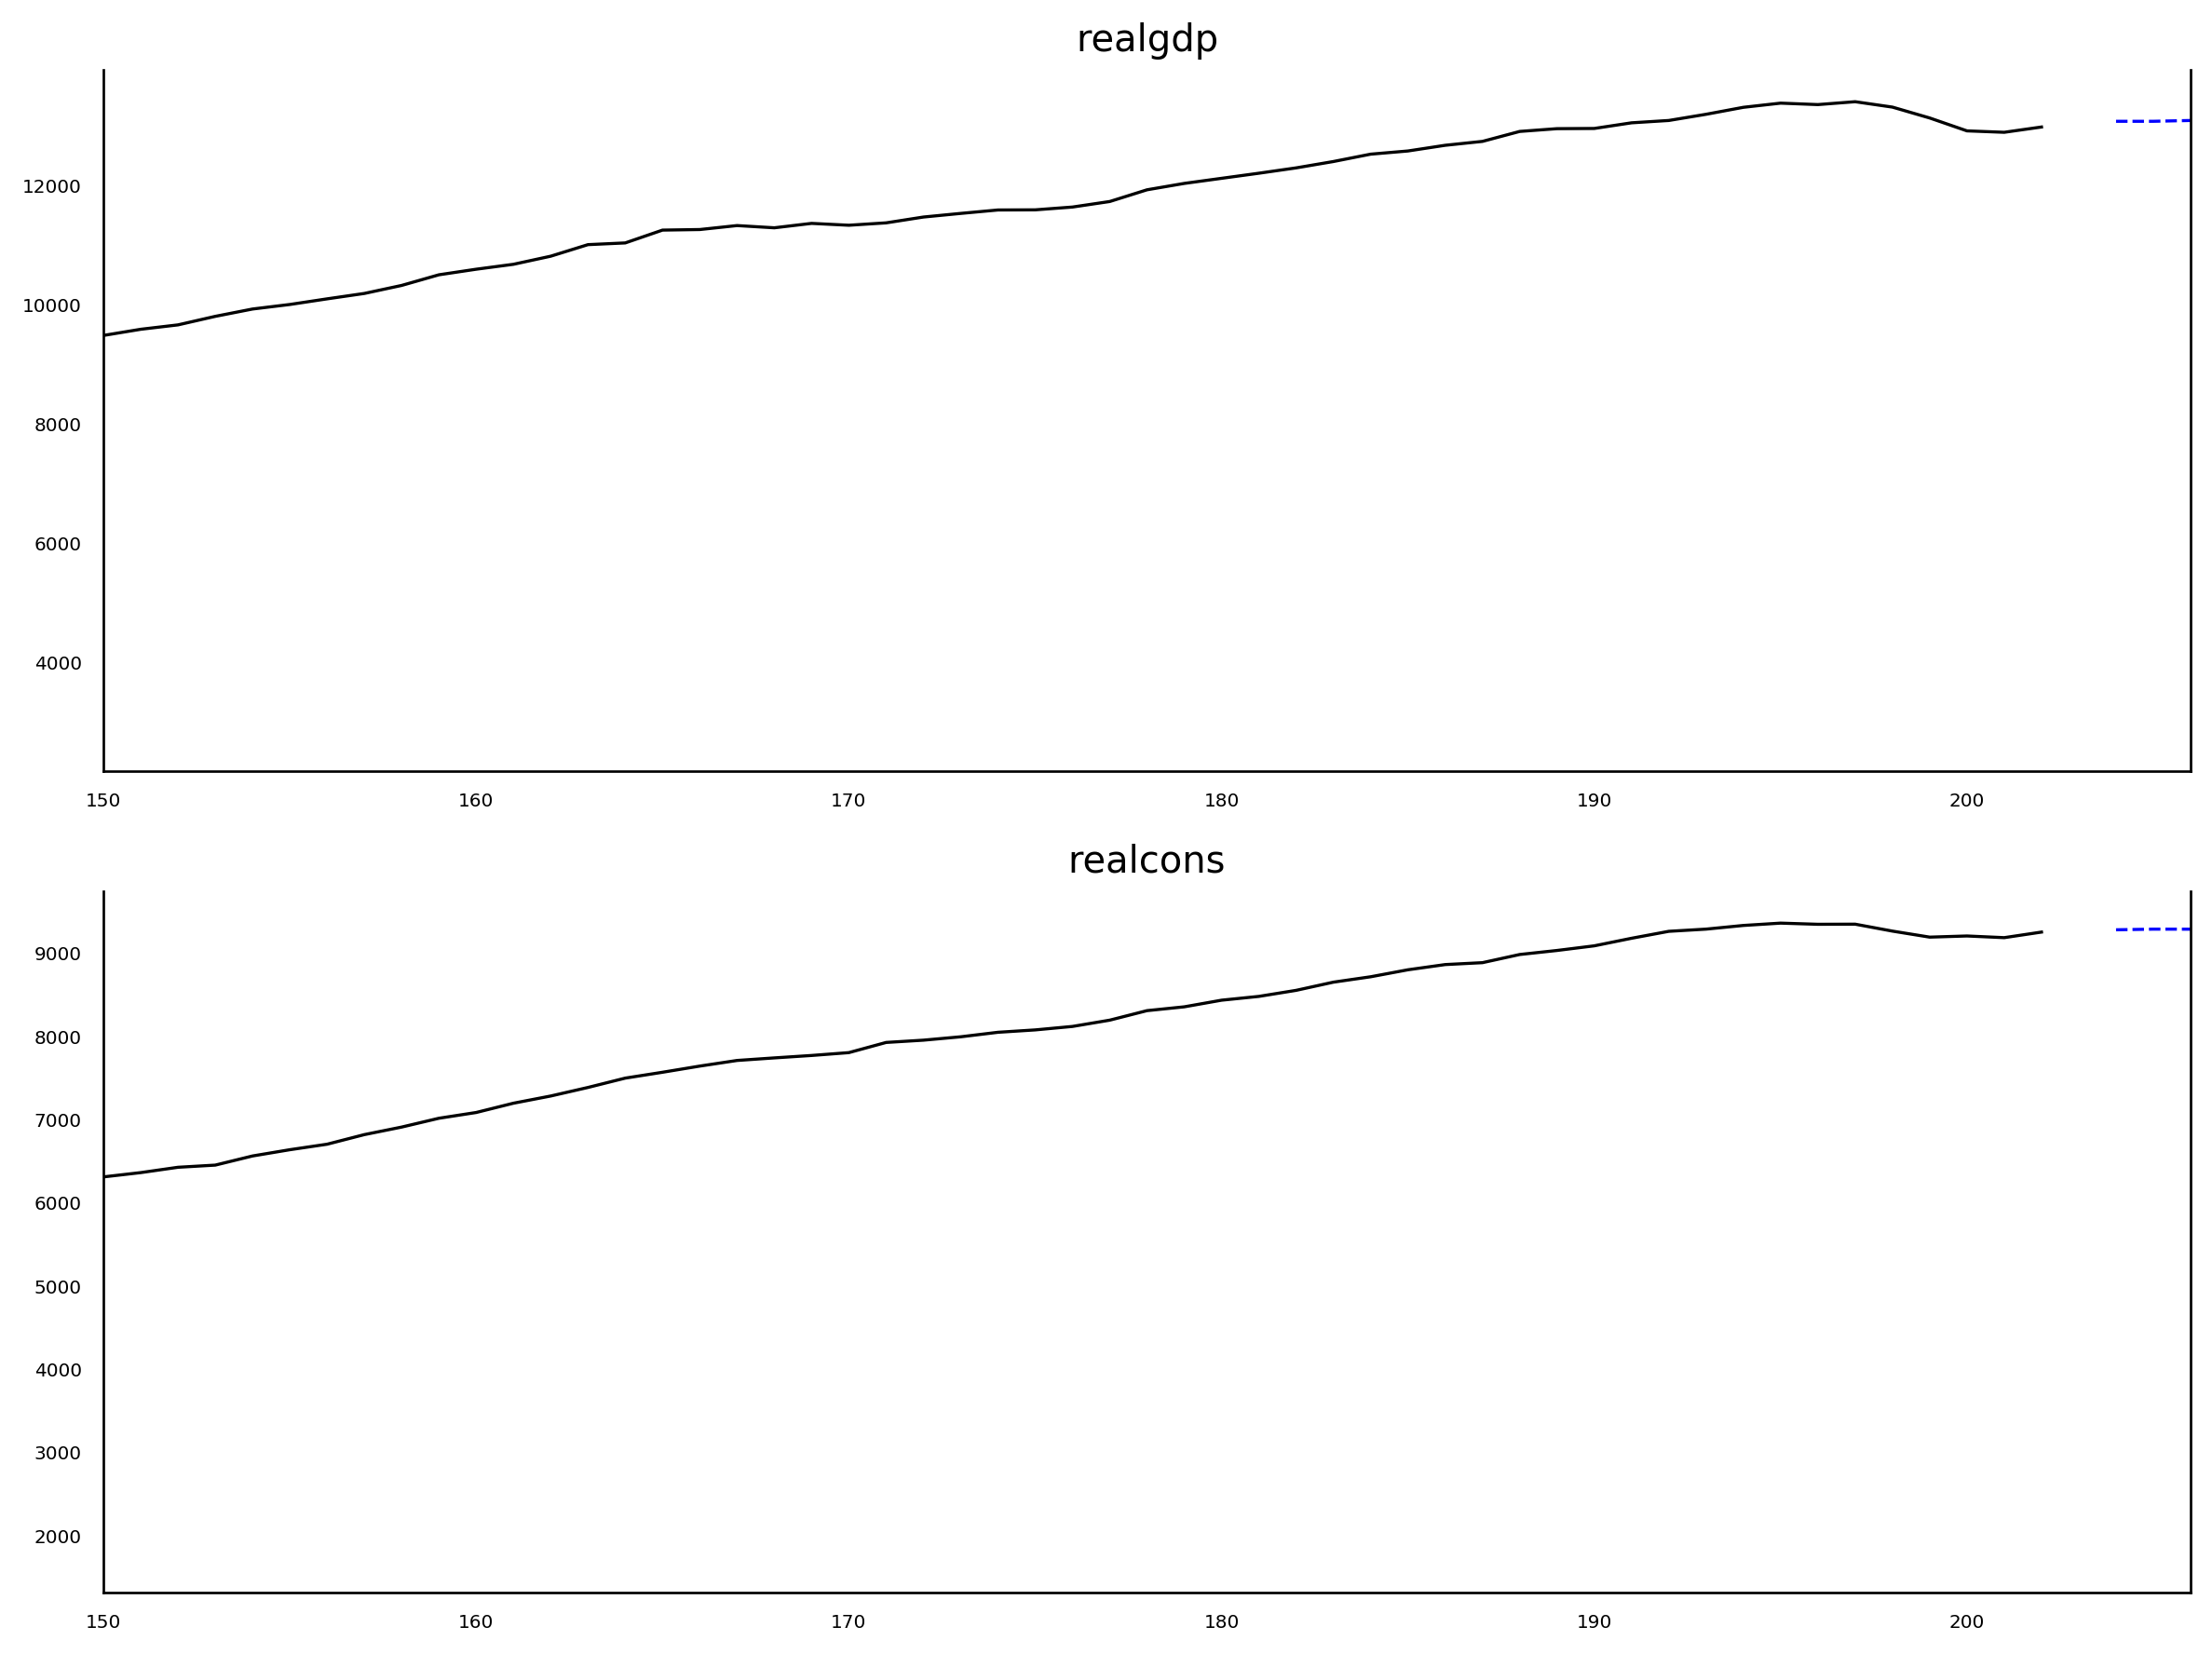

In [41]:
n_forecast = 3
predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)

idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'], color='black', linewidth=1)
ax1.plot(idx[-n_forecast:],
        predict.predicted_mean['realgdp'][-n_forecast:],
        color = 'blue',
        ls='--',
        linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150,206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)


ax2.plot(macro_data['realcons'], color='black', linewidth = 1)
ax2.plot(idx[-n_forecast:],
        predict.predicted_mean['realcons'][-n_forecast:],
        color = 'blue',
        ls='--',
        linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150,206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()